_Lambda School Data Science, Unit 2_
 
# Classification 1 Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll use information about the shot and the game to predict whether the shot was made. This is hard to predict! Try for an accuracy score in the high 50's or low 60's. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

This Sprint Challenge has two parts. To demonstrate mastery on each part, do all the required, numbered instructions. To earn a score of "3" for the part, also do the stretch goals.

## Part 1. Prepare to model

### Required

1. **Do train/validate/test split.** Use the 2009-10 season through 2016-17 season to train, the 2017-18 season to validate, and the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your train set has 11081 observations, your validation set has 1168 observations, and your test set has 1709 observations.
2. **Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is the baseline accuracy for the validation set, if you guessed the majority class for every prediction?
3. **Use Ordinal Encoding _or_ One-Hot Encoding,** for the categorical features you select.
4. **Train a Random Forest _or_ Logistic Regression** with the features you select.

### Stretch goals
Engineer at least 4 of these 5 features:

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?
    

## Part 2. Evaluate models

### Required
1. Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.)
2. Get your model's **test accuracy.** (One time, at the end.)
3. Get and plot your Random Forest's **feature importances** _or_ your Logistic Regression's **coefficients.**
4. Imagine this is the confusion matrix for a binary classification model. **Calculate accuracy, precision, and recall for this confusion matrix:**

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>


### Stretch goals
- Calculate F1 score for the provided, imaginary confusion matrix.
- Plot a real confusion matrix for your basketball model, with row and column labels.
- Print the classification report for your model.

### For the confusioin matrix given above:
- accuracy = .6470
- precision = .3723
- recall = .8181
- F1 = .5117

## Part 1

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score
from sklearn.pipeline import make_pipeline
from category_encoders import OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.utils.multiclass import unique_labels
pd.set_option('display.max_columns', 50)

In [34]:
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url, parse_dates=['game_date']).set_index('game_date')
assert df.shape == (13958, 19)

In [35]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot
game_date,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,GSW,HOU,Regular Season,2.0
2009-10-28,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,GSW,HOU,Regular Season,0.0
2009-10-28,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,GSW,HOU,Regular Season,-4.0
2009-10-28,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,GSW,HOU,Regular Season,0.0


In [36]:
# Check for NANs
df.isna().sum()

game_id                    0
game_event_id              0
player_name                0
period                     0
minutes_remaining          0
seconds_remaining          0
action_type                0
shot_type                  0
shot_zone_basic            0
shot_zone_area             0
shot_zone_range            0
shot_distance              0
loc_x                      0
loc_y                      0
shot_made_flag             0
htm                        0
vtm                        0
season_type                0
scoremargin_before_shot    0
dtype: int64

#### Engineer some features.

In [37]:
# Add columns for sec. left in the period and the game.
df['time_left_game'] = ((4 - df['period']) * 12) * 60 + df['minutes_remaining'] * 60 + df['seconds_remaining']
df['time_left_period'] = df['minutes_remaining'] * 60 + df['seconds_remaining']

In [38]:
# Add column indicating if its a home game.
df['is_home_team'] = df['htm'] == 'GSW'

In [39]:
# Add column indicating if last shot was good.
df['made_last'] = df['shot_made_flag'].shift(1)
df['made_last'].iloc[0] = 0

C:\Users\Paul\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [40]:
# Add column for opposing team name abrv.
df['opponent_hm'] = df['htm'].map(lambda x: x if x != 'GSW' else '')
df['opponent_aw'] = df['vtm'].map(lambda x: x if x != 'GSW' else '')
df['opponent'] = df['opponent_hm'] + df['opponent_aw']

In [41]:
# Reset index to use game dates.
df = df.reset_index()

In [42]:
# Add column for month and day the game took place
df['month'] = df['game_date'].dt.month
df['day'] = df['game_date'].dt.day

#### Get baseline prediction using majoity class.

In [43]:
df['shot_made_flag'].value_counts()

0    7357
1    6601
Name: shot_made_flag, dtype: int64

In [44]:
df['baseline_maj'] = 0

In [45]:
accuracy_score(df['shot_made_flag'], df['baseline_maj'])

0.5270812437311936

#### Split data into training, validation and test sets.

In [46]:
# Split data into training, validation and test sets.
train = df.query('game_date < 2017_07_01')
val = df.query('2017_07_01 < game_date < 2018_07_01')
test = df.query('game_date > 2018_07_01')
train.shape, val.shape, test.shape

((11081, 30), (1168, 30), (1709, 30))

In [47]:
# Drop columns we're not going to use.
drop = ['shot_made_flag',
        'game_date',
        'game_id',
        'game_event_id',
        'player_name',
        'period',
        'minutes_remaining',
        'seconds_remaining',
        'opponent_hm',
        'opponent_aw',
        'baseline_maj',
        'htm',
        'shot_zone_basic',
        'shot_zone_area',
        'shot_zone_range',
        'vtm']
y_train = train['shot_made_flag']
y_val = val['shot_made_flag']
y_test = test['shot_made_flag']
train = train.drop(columns=drop)
val = val.drop(columns=drop)
test = test.drop(columns=drop)
y_train.shape, y_val.shape, y_test.shape

((11081,), (1168,), (1709,))

#### Encode categorical columns.

In [48]:
# Encode categorical columns.
encoder = OrdinalEncoder()
X_train = encoder.fit_transform(train)
X_val = encoder.transform(val)
X_test = encoder.transform(test)

##### Fit a Random Forest Classifier.

In [49]:
# Fit a RandomForestClassifier.
model = RFC(n_jobs=-1,
            n_estimators=100,
            verbose=1)
model.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.8s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=1,
                       warm_start=False)

## Part 2

#### Get your model's validation accuracy.

In [50]:
predicted = model.predict(X_val)
accuracy_score(y_val, predicted)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


0.598458904109589

#### Get and plot your Random Forest's feature importances

<IPython.core.display.Javascript object>


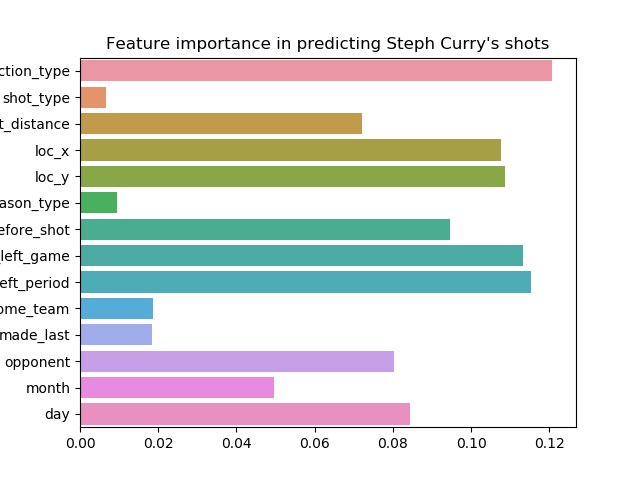

Text(0.5, 1.0, "Feature importance in predicting Steph Curry's shots")

In [62]:
fig = plt.figure()
ax = fig.gca()
sns.barplot(model.feature_importances_, X_train.columns, orient='h', ax=ax)
plt.title('Feature importance in predicting Steph Curry\'s shots')

In [52]:
cm = confusion_matrix(y_val, predicted)

In [53]:
def nice_confusion(matrix, y_val):
    labels = unique_labels(y_val)
    columns = ['Predicted made' if label == 1 else 'Predicted missed' for label in labels]
    index = ['Actual made' if label == 1 else 'Actual missed' for label in labels]
    table = pd.DataFrame(cm, columns=columns, index=index)
    fig = plt.figure()
    ax = fig.gca()
    sns.heatmap(table, annot=True, fmt='d', ax=ax);

<IPython.core.display.Javascript object>


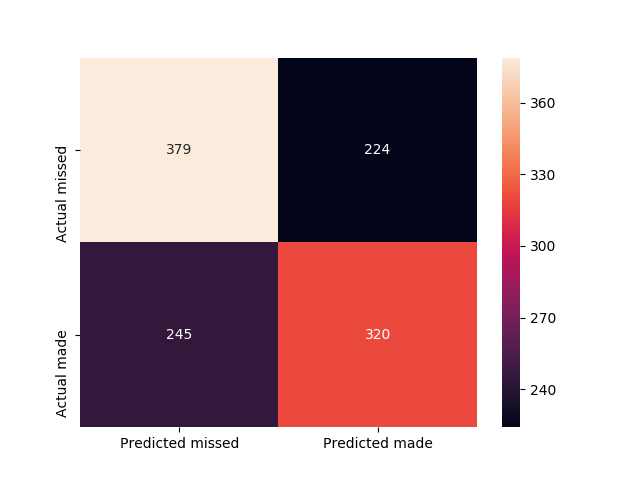

In [61]:
nice_confusion(cm, y_val)

In [55]:
print(classification_report(y_val, predicted))

              precision    recall  f1-score   support

           0       0.61      0.63      0.62       603
           1       0.59      0.57      0.58       565

    accuracy                           0.60      1168
   macro avg       0.60      0.60      0.60      1168
weighted avg       0.60      0.60      0.60      1168



In [56]:
f1_score(y_val, predicted)

0.5770964833183048

#### Get your model's test accuracy

Final Accuracy: 0.6266822703335284


<IPython.core.display.Javascript object>


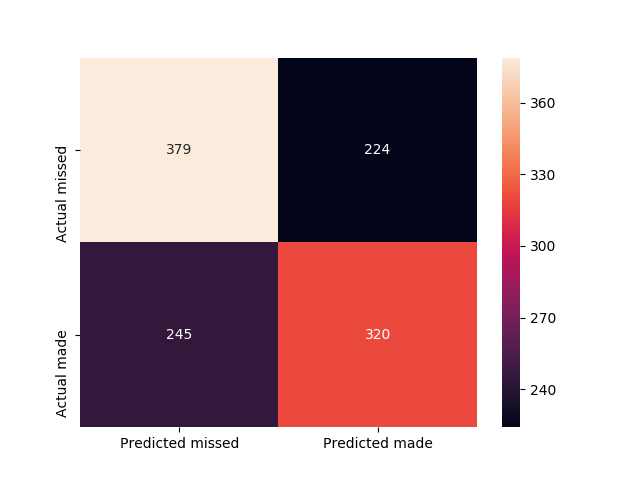

In [60]:
# Let's try it on our test set and see how we've done!
final = model.predict(X_test)
print(f'Final Accuracy: {accuracy_score(y_test, final)}')
nice_confusion(confusion_matrix(y_test, final), y_test)

In [58]:
# Run this cell if you're on Colab!
# !pip install pandas==0.23.4

In [59]:
train['x_bins'] = pd.cut(train['loc_x'], 20)
train['y_bins'] = pd.cut(train['loc_y'], 20)
locs = train[['x_bins', 'y_bins']]
locs = OrdinalEncoder().fit_transform(locs)
locs['hit'] = y_train
pivot = locs.pivot_table(values='hit',
                         index='x_bins',
                         columns='y_bins')
sns.heatmap(pivot)

C:\Users\Paul\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


TypeError: Cannot cast array data from dtype('float64') to dtype('<U32') according to the rule 'safe'